# Training with ImageDataGenerator

download horse-or-human.zip: open cmd and run this command below (in window sys):  
curl -o horse-or-human.zip https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip


In [8]:
import zipfile

# Unzip the dataset
local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory *./horse-or-human*, which in turn each contain *horses* and *humans* subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a horse looks like' and 'this is what a human looks like'.

One thing to pay attention to in this sample: We do not explicitly label the images as horses or humans. You will use the ImageDataGenerator API instead -- and this is coded to automatically label images according to the directory names and structure. So, for example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. *ImageDataGenerator* will label the images appropriately for you, reducing a coding step.

You can now define each of these directories:

In [9]:
import os

#directory with training horses pictures
train_horse_dir = os.path.join('horse-or-human/horses')

#directory with training human pitures
train_human_dir = os.path.join('horse-or-human/humans')

In [10]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

['horse01-0.png', 'horse01-1.png', 'horse01-2.png', 'horse01-3.png', 'horse01-4.png', 'horse01-5.png', 'horse01-6.png', 'horse01-7.png', 'horse01-8.png', 'horse01-9.png']
['human01-00.png', 'human01-01.png', 'human01-02.png', 'human01-03.png', 'human01-04.png', 'human01-05.png', 'human01-06.png', 'human01-07.png', 'human01-08.png', 'human01-09.png']
total training horse images: 500
total training human images: 527


Now take a look at a few pictures to get a better sense of what they look like.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#parameters 4 graphs; we'll output the image in 4x4 configuration
nrows = 4
ncols = 4

#index for iterating over images
pic_index = 0

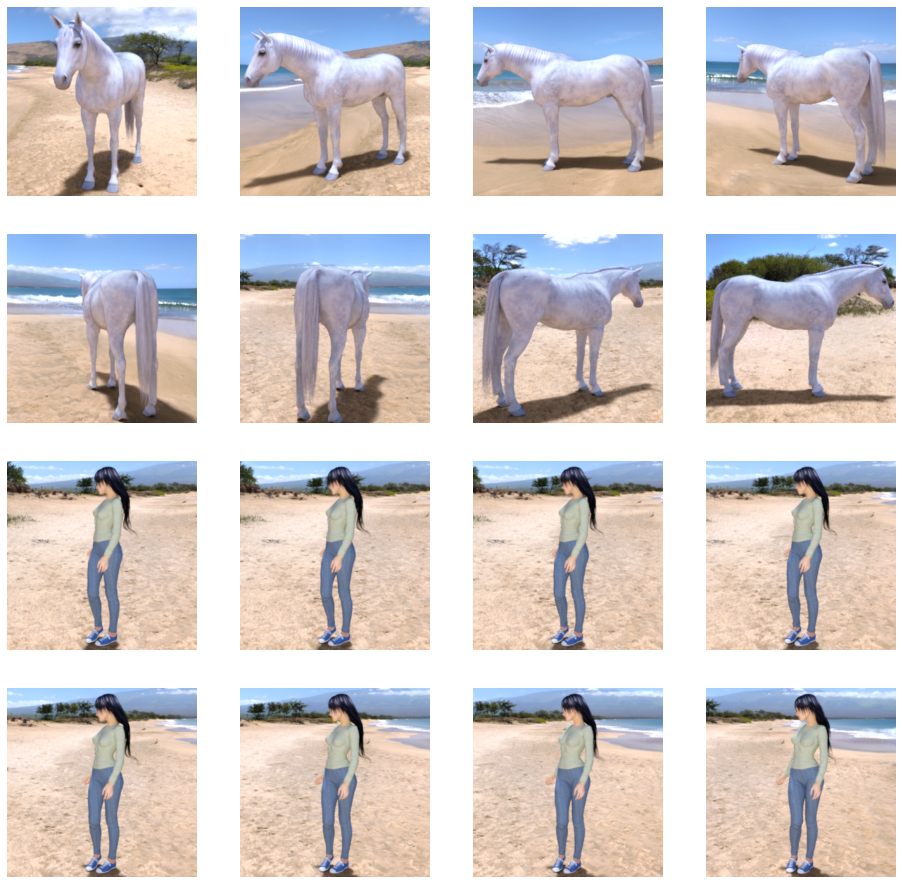

In [12]:
#set up matplot fig, and size it to 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Building a small modelo from Scratch

In [13]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    #this input shape is desired size of 300x300 cells and 3 bytes colors
    # the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #the second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #the third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #the fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #the fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #flatten layers to feed the output
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 35, 35, 64)       

The "output shape" column shows how the size of your feature map evolves in each successive layer. As you saw in an earlier lesson, the convolution layers removes the outermost pixels of the image, and each pooling layer halves the dimensions.

Next, you'll configure the specifications for model training. You will train the model with the binary_crossentropy loss because it's a binary classification problem, and the final activation is a sigmoid. (For a refresher on loss metrics, see this Machine Learning Crash Course.) You will use the rmsprop optimizer with a learning rate of 0.001. During training, you will want to monitor classification accuracy.

NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

In [14]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=0.001),
                metrics=['accuracy'])

## Data preprocessing
Next step is to set up the data generators that will read pictures in the source folders, convert them to *float32* tensors, and feed them (with their labels) to the model. You'll have one generator for the training images and one for the validation images. These generators will yield batches of images of size 300x300 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network (i.e. It is uncommon to feed raw pixels into a ConvNet.) In this case, you will preprocess the images by normalizing the pixel values to be in the *[0, 1]* range (originally all values are in the *[0, 255]* range).

In Keras, this can be done via the *keras.preprocessing.image.ImageDataGenerator* class using the *rescale* parameter. This *ImageDataGenerator class* allows you to instantiate generators of augmented image batches (and their labels) via *.flow(data, labels)* or *.flow_from_directory(directory)*.

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# all images will be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale = 1/255)

#flow training data in batches of 128 using train data generator
train_generator = train_datagen.flow_from_directory(
    './horse-or-human/', #source directory for image data
    target_size=(300, 300),
    batch_size=128,
    #since we use binary_crossentropy loss, we need binary labels
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


In [16]:
history = model.fit(
    train_generator, 
    steps_per_epoch=8,
    epochs=15,
    verbose=1
)

Epoch 1/15
8/8 [==============================] - 59s 6s/step - loss: 0.7401 - accuracy: 0.4939
Epoch 2/15
8/8 [==============================] - 51s 6s/step - loss: 0.6574 - accuracy: 0.6270
Epoch 3/15
8/8 [==============================] - 51s 6s/step - loss: 0.7113 - accuracy: 0.7305
Epoch 4/15
8/8 [==============================] - 45s 5s/step - loss: 0.5001 - accuracy: 0.8187
Epoch 5/15
8/8 [==============================] - 46s 5s/step - loss: 0.3797 - accuracy: 0.8598
Epoch 6/15
8/8 [==============================] - 45s 5s/step - loss: 0.7113 - accuracy: 0.7553
Epoch 7/15
8/8 [==============================] - 45s 5s/step - loss: 0.2081 - accuracy: 0.9266
Epoch 8/15
8/8 [==============================] - 45s 5s/step - loss: 0.3084 - accuracy: 0.8710
Epoch 9/15
8/8 [==============================] - 46s 5s/step - loss: 0.2747 - accuracy: 0.8899
Epoch 10/15
8/8 [==============================] - 45s 5s/step - loss: 0.1761 - accuracy: 0.9299
Epoch 11/15
8/8 [======================

## model prediction
Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

*Note: Old versions of the Safari browser might have compatibility issues with the code block below. If you get an error after you select the images(s) to upload, you can consider updating your browser to the latest version. If not possible, please comment out or skip the code block below, uncomment the next code block and run it.*

['360_F_292287867_hC2Owo0yInRruYbxZXKoJZhB7YUCHdmp.jpg', 'download (1).jfif', 'download.jfif', 'images (1).jfif', 'images (2).jfif', 'images (3).jfif', 'images.jfif']

1/1 [==============================] - 0s 70ms/step
[0.7719247]


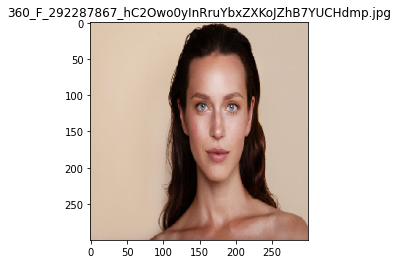

360_F_292287867_hC2Owo0yInRruYbxZXKoJZhB7YUCHdmp.jpg is a human

1/1 [==============================] - 0s 69ms/step
[0.9989865]


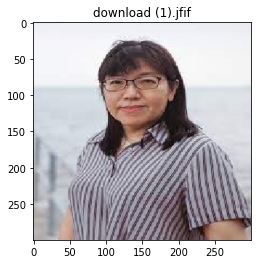

download (1).jfif is a human

1/1 [==============================] - 0s 60ms/step
[1.7697372e-08]


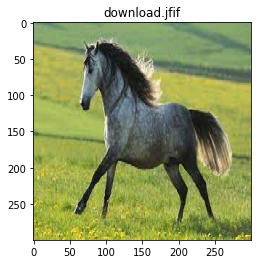

download.jfif is a horse

1/1 [==============================] - 0s 69ms/step
[0.09783246]


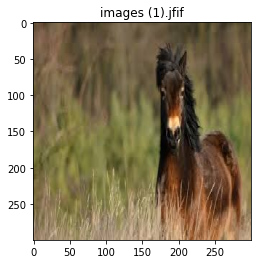

images (1).jfif is a horse

1/1 [==============================] - 0s 76ms/step
[2.668145e-09]


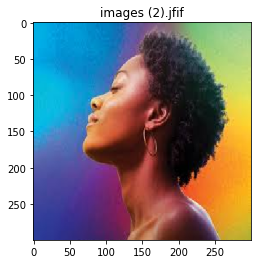

images (2).jfif is a horse

1/1 [==============================] - 0s 78ms/step
[0.98930925]


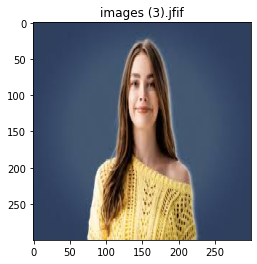

images (3).jfif is a human

1/1 [==============================] - 0s 93ms/step
[0.8716848]


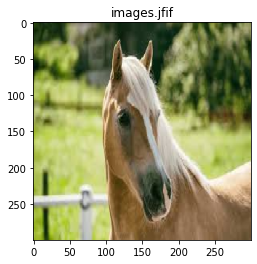

images.jfif is a human


In [25]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

images = os.listdir("/machine learning/practice/tensorflow/images")
print(images)

for i in images:
    print()
    # predicting images
    path = '/machine learning/practice/tensorflow/images/' + i
    img = load_img(path, target_size=(300, 300))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])

    plt.imshow(img)
    plt.title(i)
    plt.show()

    if classes[0]>0.5:
        print(i + " is a human")
    else:
        print(i + " is a horse")

## visualizing intermediate representations
To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

In [1]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# define an new model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after the first

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

#prepare a random input image from the training dataset
horse_img_file = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_file = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_file + human_img_file)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 300, 300, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
        x = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std()
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
    
        # Tile each filter into this big horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')s

NameError: name 'model' is not defined